In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from prettytable import PrettyTable
from torch import Tensor
from torch_geometric.loader import ClusterData, ClusterLoader, NeighborSampler
from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import zeros
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_sparse import SparseTensor, fill_diag, matmul, mul
from tqdm import tqdm
from typing import Optional, Tuple
gpu_id = 3 # replace with index in [0, torch.cuda.device_count()]
device = torch.device("cuda:" + str(gpu_id) if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:3


## Helpers

In [2]:
# Logger object.
class Logger(object):
    def __init__(self, runs):
        self.results = [[] for _ in range(runs)]

    def add_result(self, run, result):
        assert len(result) == 3
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def get_stats(self):
        result = 100 * torch.tensor(self.results)

        best_results = []
        for r in result:
            test = r[r[:, 1].argmax(), 2].item()
            best_results.append(test)

        return torch.tensor(best_results)

# MLP with ReLU activations.
class MLP(torch.nn.Module):
    def __init__(self, num_layers, in_channels, hidden_channels, out_channels):
        super(MLP, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))
        self.dropout = 0.5

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x):
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lins[-1](x)
    
gcn_norm = pyg_nn.conv.gcn_conv.gcn_norm

# GCNConv module modified to consider multiple convolutions.
class GraphConv(MessagePassing):
    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(
        self, in_channels: int, out_channels: int, bias: bool = True,
        num_convs: int = 1, cached: bool = False, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_convs = num_convs
        self.cached = cached
        self._cached_edge_index = None
        self._cached_adj_t = None

        self.lin = nn.Linear(in_channels, out_channels, bias=False)

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj, edge_weight: OptTensor = None) -> Tensor:
        edge_index, edge_weight = gcn_norm(
            edge_index, edge_weight, x.size(self.node_dim),
            False, True)
        x = self.lin(x)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = x
        for i in range(self.num_convs):
            out = self.propagate(edge_index, x=out, edge_weight=edge_weight, size=None)

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)
    
# GCN with ReLU activations and sigmoidal output.
class GCN(torch.nn.Module):
    def __init__(self, num_layers, in_channels, hidden_channels, out_channels, num_convs):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(in_channels, hidden_channels, num_convs=num_convs[0], cached=False))
        for _ in range(num_layers - 2):
            self.convs.append(
                GraphConv(hidden_channels, hidden_channels, num_convs=num_convs[_+1], cached=False))
        self.convs.append(GraphConv(hidden_channels, out_channels, num_convs=num_convs[-1], cached=False))
        self.dropout = 0.5

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.convs[-1](x, edge_index)
    
# Function to train a model, 1 epoch.
def train(model, loader, optimizer, device):
    model.train()
    total_loss = total_examples = 0
    total_correct = total_examples = 0
    for data in loader:
        data = data.to(device)
        if data.train_mask.sum() == 0:
            continue
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)[data.train_mask]
        y = data.y.squeeze(1)[data.train_mask]
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()

        num_examples = data.train_mask.sum().item()
        total_loss += loss.item() * num_examples
        total_examples += num_examples

        total_correct += out.argmax(dim=-1).eq(y).sum().item()
        total_examples += y.size(0)

    return total_loss / total_examples, total_correct / total_examples

# Function to evaluate a model.
@torch.no_grad()
def test(model, loader, evaluator, device):
    model.eval()
    train_accs = []
    valid_accs = []
    test_accs = []
    total_nodes = 0
    for data in loader:
        data = data.to(device)
        out = torch.log_softmax(model(data.x, data.edge_index), dim=-1)

        y_true = data.y
        y_pred = out.argmax(dim=-1, keepdim=True)
        total_nodes += data.x.size(0)

        train_accs.append(data.x.size(0)*evaluator.eval({
            'y_true': y_true[data.train_mask],
            'y_pred': y_pred[data.train_mask]
        })['acc'])
        valid_accs.append(data.x.size(0)*evaluator.eval({
            'y_true': y_true[data.valid_mask],
            'y_pred': y_pred[data.valid_mask]
        })['acc'])
        test_accs.append(data.x.size(0)*evaluator.eval({
            'y_true': y_true[data.test_mask],
            'y_pred': y_pred[data.test_mask]
        })['acc'])
    
    train_acc = torch.tensor(train_accs).sum()/total_nodes
    valid_acc = torch.tensor(valid_accs).sum()/total_nodes
    test_acc = torch.tensor(test_accs).sum()/total_nodes

    return train_acc, valid_acc, test_acc


def train_mlp(model, x, y_true, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(x[train_idx])
    loss = F.cross_entropy(out, y_true.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test_mlp(model, x, y_true, split_idx, evaluator):
    model.eval()

    out = torch.log_softmax(model(x), dim=-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

## Learners and Plot Helpers

In [3]:
model_types = [
    'MLP3', # 3 layer MLP
    '3L-001', # 3 layer GCN with 1 GC at layer 3
    '3L-010', # 3 layer GCN with 1 GC at layer 2
    '3L-100', # 3 layer GCN with 1 GC at layer 1
    '3L-011', # 3 layer GCN with 1 GC each at layers 2 and 3
    '3L-110', # 3 layer GCN with 1 GC each at layers 1 and 2
    '3L-002', # 3 layer GCN with 2 GCs at layer 3
    '3L-020', # 3 layer GCN with 2 GCs at layer 2
    '3L-111', # 3 layer GCN with 1 GC at each layer
    '3L-021', # 3 layer GCN
    '3L-012', # 3 layer GCN
    '3L-102', # 3 layer GCN
    '3L-003', # 3 layer GCN with 3 GCs at layer 3
    '3L-030', # 3 layer GCN with 3 GCs at layer 2
    '3L-300', # 3 layer GCN with 3 GCs at layer 1
]

# Initialize all learning models.
def init_learners(n_features, n_classes, hidden_channels=256):
    learners = {}
    learners['MLP3'] = MLP(3, n_features, hidden_channels, n_classes).to(device)
    learners['3L-001'] = GCN(3, n_features, hidden_channels, n_classes, [0, 0, 1]).to(device)
    learners['3L-010'] = GCN(3, n_features, hidden_channels, n_classes, [0, 1, 0]).to(device)
    learners['3L-100'] = GCN(3, n_features, hidden_channels, n_classes, [1, 0, 0]).to(device)
    learners['3L-011'] = GCN(3, n_features, hidden_channels, n_classes, [0, 1, 1]).to(device)
    learners['3L-110'] = GCN(3, n_features, hidden_channels, n_classes, [1, 1, 0]).to(device)
    learners['3L-002'] = GCN(3, n_features, hidden_channels, n_classes, [0, 0, 2]).to(device)
    learners['3L-020'] = GCN(3, n_features, hidden_channels, n_classes, [0, 2, 0]).to(device)
    learners['3L-111'] = GCN(3, n_features, hidden_channels, n_classes, [1, 1, 1]).to(device)
    learners['3L-021'] = GCN(3, n_features, hidden_channels, n_classes, [0, 2, 1]).to(device)
    learners['3L-012'] = GCN(3, n_features, hidden_channels, n_classes, [0, 1, 2]).to(device)
    learners['3L-102'] = GCN(3, n_features, hidden_channels, n_classes, [1, 0, 2]).to(device)
    learners['3L-003'] = GCN(3, n_features, hidden_channels, n_classes, [0, 0, 3]).to(device)
    learners['3L-030'] = GCN(3, n_features, hidden_channels, n_classes, [0, 3, 0]).to(device)
    learners['3L-300'] = GCN(3, n_features, hidden_channels, n_classes, [3, 0, 0]).to(device)
    return learners

alph = .8
black = (.2, .2, .2, alph)
red = (.8, .1, .1, alph)
green = (.1, .8, .1, alph)
blue = (0., .3, .8, alph)
orange = (1., .6, .1, alph)
colors=[black] + [red]*3 + [blue]*4 + [green]*7

colors_std = []
for color in colors:
    color_std = (color[0], color[1], color[2], alph/3.)
    colors_std.append(color_std)

In [4]:
def plot_for_models(ds_name, x_axis, y_axis, y_err, y_label, filename=None):
    fig = plt.figure(figsize=(16,4), facecolor=[1,1,1])
    y_axis = np.asarray(y_axis)
    if y_err is None:
        y_err = np.zeros(len(x_axis))
    else:
        y_err = np.asarray(y_err)
    plt.ylim((0, 1.2*np.max(y_axis+y_err)))
    plt.bar(x_axis, y_axis, color=colors, width=0.6)
    plt.bar(x_axis, 2*y_err, color=colors_std, width=0.6, bottom=np.maximum(y_axis-y_err, np.zeros(y_axis.shape)))
    plt.xticks(x_axis, [s.upper() for s in model_types])
    txt_gap = .1*np.max(y_axis)
    for i, v in enumerate(y_axis):
        plt.text(i-.25, v + txt_gap, " "+str(round(v, 2)), color='black', va='center', fontweight='bold')
    plt.xlabel('Model', fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.show()
    if filename is not None:
        fig.savefig("figures/custom-gcnconv/" + filename, dpi=400, bbox_inches='tight')

def plot_metrics(ds, x_axis, t_acc_avg, t_acc_std, t_acc_max):
    fname = ds + '_test_acc_avg.pdf'
    plot_for_models(ds, x_axis, t_acc_avg, t_acc_std, 'Accuracy (avg)', fname)
    fname = ds + '_test_acc_max.pdf'
    plot_for_models(ds, x_axis, t_acc_max, None, 'Accuracy (max)', fname)

def print_metrics(ds, t_acc_avg, t_acc_std, t_acc_max):
    t = PrettyTable(['Model Name', 'Accuracy', 'Accuracy (max)'])
    for m, mtype in enumerate(model_types):
        t.add_row([
            mtype,
            f'{t_acc_avg[m].item():.2f}' + u' \u00B1 ' + f'{t_acc_std[m].item():.2f}',
            f'{t_acc_max[m].item():.2f}'])
    print('METRICS FOR DATASET:', ds.upper())
    print(t)

## Train and test all models

In [5]:
dataset = PygNodePropPredDataset(name='ogbn-products', root='./products')
split_idx = dataset.get_idx_split()
data = dataset[0]

# Convert split indices to boolean masks and add them to `data`.
for key, idx in split_idx.items():
    mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    mask[idx] = True
    data[f'{key}_mask'] = mask

cluster_data = ClusterData(
    data, num_parts=15000, recursive=False, save_dir=dataset.processed_dir)

loader = ClusterLoader(
    cluster_data, batch_size=320, shuffle=True, num_workers=12)

subgraph_loader = NeighborSampler(
    data.edge_index, sizes=[-1], batch_size=1024, shuffle=False, num_workers=12)


n_classes = dataset.num_classes
n_points, n_features = data.num_nodes, data.num_features
train_idx = split_idx['train'].to(device)


Working on ogbn-products: Classes=47 | Points=2449029 | Features=100.
Trial: 5 with 3L-300, Epoch: 50, Loss: 0.2338, Train: 89.64%, Valid: 88.63% Test: 71.11%           METRICS FOR DATASET: OGBN-PRODUCTS
+------------+--------------+----------------+
| Model Name |   Accuracy   | Accuracy (max) |
+------------+--------------+----------------+
|    MLP3    | 43.93 ± 0.29 |     44.30      |
|   3L-001   | 70.76 ± 0.39 |     71.27      |
|   3L-010   | 71.05 ± 0.12 |     71.22      |
|   3L-100   | 69.04 ± 0.04 |     69.08      |
|   3L-011   | 74.35 ± 0.38 |     74.64      |
|   3L-110   | 73.65 ± 0.16 |     73.81      |
|   3L-002   | 73.97 ± 0.42 |     74.64      |
|   3L-020   | 73.39 ± 0.11 |     73.51      |
|   3L-111   | 74.47 ± 0.22 |     74.85      |
|   3L-021   | 74.26 ± 0.25 |     74.55      |
|   3L-012   | 74.42 ± 0.25 |     74.72      |
|   3L-102   | 74.02 ± 0.18 |     74.29      |
|   3L-003   | 74.19 ± 0.21 |     74.36      |
|   3L-030   | 73.05 ± 0.29 |     73.40    

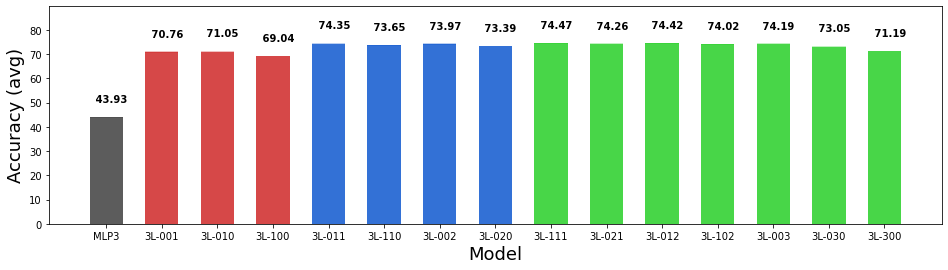

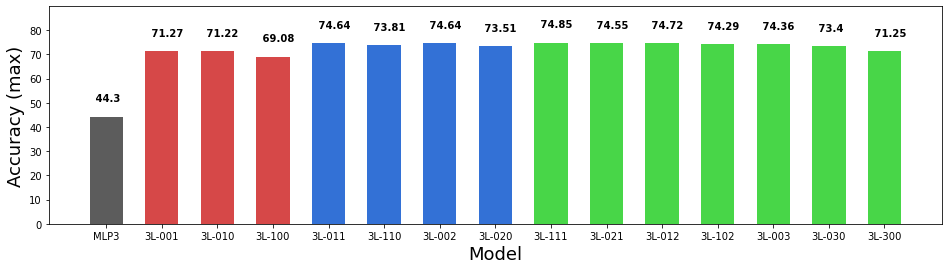

In [6]:
n_trials = 5
epochs = 50
print(f'\nWorking on {dataset.name}:',
      f'Classes={n_classes} |',
      f'Points={n_points} |',
      f'Features={n_features}.')
test_acc_avg = torch.zeros(len(model_types))
test_acc_std = torch.zeros(len(model_types))
test_acc_max = torch.zeros(len(model_types))
learners = init_learners(n_features, n_classes)
for m, model_type in enumerate(model_types):
    model = learners[model_type]
    evaluator = Evaluator(name='ogbn-products')
    logger = Logger(n_trials)
    if model_type == 'MLP3':
        x = data.x
        x = x.to(device)
        y_true = data.y.to(device)
        train_idx = split_idx['train'].to(device)
        
    for t in range(n_trials):
        # Reset and train model.
        model.reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        for epoch in range(1, 1 + epochs):
            if model_type == 'MLP3':
                loss = train_mlp(model, x, y_true, train_idx, optimizer)
                result = test_mlp(model, x, y_true, split_idx, evaluator)
            else:
                loss, train_acc = train(model, loader, optimizer, device)
                result = test(model, loader, evaluator, device)
            logger.add_result(t, result)
            wspace = ' '*10
            train_acc, valid_acc, test_acc = result
            print(f'\rTrial: {t + 1} with {model_type}, '
                  f'Epoch: {epoch:02d}, '
                  f'Loss: {loss:.4f}, '
                  f'Train: {100 * train_acc:.2f}%, '
                  f'Valid: {100 * valid_acc:.2f}% '
                  f'Test: {100 * test_acc:.2f}%', wspace, end='')
    
    # Get test metrics from accumulated test results.
    test_acc_list = logger.get_stats()
    test_acc_avg[m] = test_acc_list.mean().item()
    test_acc_std[m] = test_acc_list.std().item()
    test_acc_max[m] = test_acc_list.max().item()

x_axis = torch.arange(len(model_types))
print_metrics(dataset.name, test_acc_avg, test_acc_std, test_acc_max)
plot_metrics(dataset.name, x_axis, test_acc_avg, test_acc_std, test_acc_max)

## Plot and print metrics

METRICS FOR DATASET: OGBN-PRODUCTS
+------------+--------------+----------------+
| Model Name |   Accuracy   | Accuracy (max) |
+------------+--------------+----------------+
|    MLP3    | 43.93 ± 0.29 |     44.30      |
|   3L-001   | 70.76 ± 0.39 |     71.27      |
|   3L-010   | 71.05 ± 0.12 |     71.22      |
|   3L-100   | 69.04 ± 0.04 |     69.08      |
|   3L-011   | 74.35 ± 0.38 |     74.64      |
|   3L-110   | 73.65 ± 0.16 |     73.81      |
|   3L-002   | 73.97 ± 0.42 |     74.64      |
|   3L-020   | 73.39 ± 0.11 |     73.51      |
|   3L-111   | 74.47 ± 0.22 |     74.85      |
|   3L-021   | 74.26 ± 0.25 |     74.55      |
|   3L-012   | 74.42 ± 0.25 |     74.72      |
|   3L-102   | 74.02 ± 0.18 |     74.29      |
|   3L-003   | 74.19 ± 0.21 |     74.36      |
|   3L-030   | 73.05 ± 0.29 |     73.40      |
|   3L-300   | 71.19 ± 0.06 |     71.25      |
+------------+--------------+----------------+


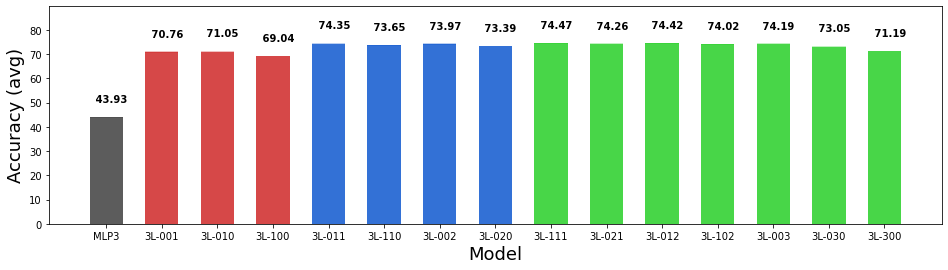

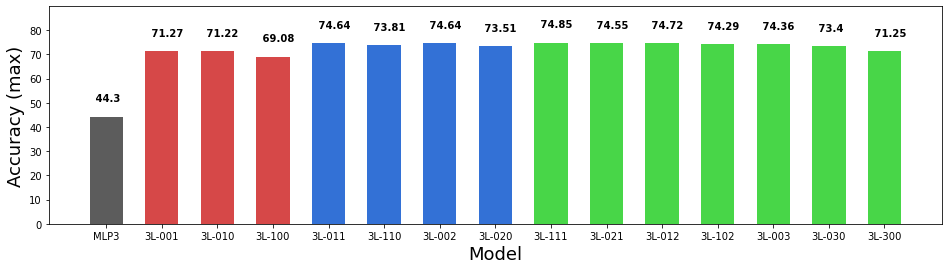

In [7]:
x_axis = torch.arange(len(model_types))
print_metrics(dataset.name, test_acc_avg, test_acc_std, test_acc_max)
plot_metrics(dataset.name, x_axis, test_acc_avg, test_acc_std, test_acc_max)